In [1]:
import statsmodels.api as sm
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

In [2]:
pd.set_option("future.no_silent_downcasting", True)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Strategy #1: Volume Adjusted Momentum

In [ ]:
# Downloading Data 

client = bnb_client(tld='US')

def get_binance_px(symbol, freq, start_ts = '2020-01-01', end_ts='2024-06-30'):
    data = client.get_historical_klines(symbol, freq, start_ts, end_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 

univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','DOTUSDT', 'MATICUSDT']
start_ts = '2020-01-01'
end_ts = '2024-06-30'

freq = '1h'
px = pd.DataFrame() 
for x in univ:
    df = get_binance_px(x, freq, start_ts, end_ts).set_index('open_time')
    px[f'{x} Close'] = df['close'].astype(float)
    px[f'{x} Vol'] = df['volume'].astype(float)

freq = '1d'
px_w = pd.DataFrame() 
for x in univ:
    df = get_binance_px(x, freq, start_ts, end_ts).set_index('open_time')
    px_w[f'{x} Close'] = df['close'].astype(float)
    px_w[f'{x} Vol'] = df['volume'].astype(float)

In [5]:
print(px_w.index)
print(df.index)

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2024-06-21', '2024-06-22', '2024-06-23', '2024-06-24',
               '2024-06-25', '2024-06-26', '2024-06-27', '2024-06-28',
               '2024-06-29', '2024-06-30'],
              dtype='datetime64[ns]', length=1643, freq='D')
DatetimeIndex(['2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12',
               '2022-01-13', '2022-01-14',
               ...
               '2024-06-21', '2024-06-22', '2024-06-23', '2024-06-24',
               '2024-06-25', '2024-06-26', '2024-06-27', '2024-06-28',
               '2024-06-29', '2024-06-30'],
              dtype='datetime64[ns]', name='open_time', length=908, freq=None)


In [6]:
# Preparing Data
ret = px.pct_change() 
rets = ret.drop(ret.columns[6:], axis=1)
vols = ret.drop(ret.columns[:6], axis=1)
info_rets = rets
info_vols = ret[ret.columns[6:]] # Last usage of ret
for i in vols.index:
    info_vols.loc[i] = pd.to_numeric(vols.loc[i])

/tmp/ipykernel_651985/3670290944.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_vols.loc[i] = pd.to_numeric(vols.loc[i])


In [7]:
# Required Functions

def compounded_rolling(x):
    return (x + 1).prod() - 1
    
# creating time framed data
def info_creating_timed_data(returns = info_rets, vols = info_vols, time_frame = 4):
    timed_info_rets = returns.shift(time_frame - 1).resample(f'{time_frame}h').apply(compounded_rolling)
    timed_info_vols = vols.shift(time_frame - 1).resample(f'{time_frame}h').mean()
    timed_info_rets.columns = ['BTCUSDT', 'ETHUSDT', 'ADAUSDT', 'BNBUSDT', 'DOTUSDT', 'MATICUSDT']
    timed_info_vols.columns = timed_info_rets.columns
    return timed_info_rets, timed_info_vols

# signal building
def info_build_signal(timed_info_rets, timed_info_vols, longer_trend = 10):
    info_weights = (timed_info_vols - timed_info_vols.rolling(longer_trend, min_periods=1).mean()) \
        / timed_info_vols.rolling(longer_trend, min_periods=1).mean() * timed_info_rets
    info_weights = info_weights.subtract(info_weights.mean(1), 0)
    info_weights = info_weights.divide(info_weights.abs().sum(1).replace(0, 1e-5), 0)
    return info_weights

# portfolio building
def info_build_port(info_weights, timed_info_rets):
    info_port = info_weights * timed_info_rets
    # (info_port.sum(1) - 0.002).cumsum().plot()
    return info_port

sharpe = lambda x: x.sum(1).mean() / x.sum(1).std()
sharpe_tcosts = lambda x: (x.sum(1) - 0.002).mean() / (x.sum(1) - 0.002).std()

/home/ak/Dropbox/Career/Training/QuantResearch/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:56: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/home/ak/Dropbox/Career/Training/QuantResearch/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/ak/Dropbox/Career/Training/QuantResearch/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/ak/Dropbox/Career/Training/QuantResearch/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/ak/Dropbox/Career/Training/QuantResearch/.venv/lib/python3.12/site-packages/numpy/_core/_

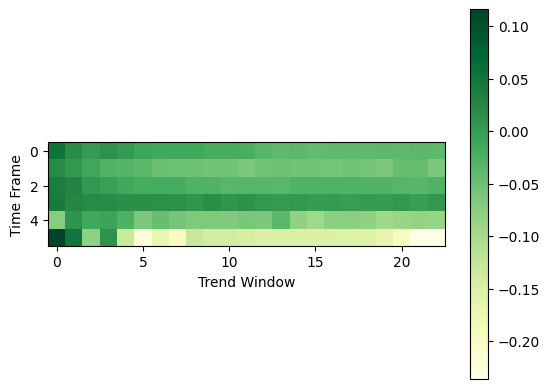

In [8]:
# Grid Search

grid = [[0 for i in range(23)] for i in range(6)]
o = [4, 8, 12, 24, 168, 720]
opt = {}
row, col = 0, 0
for i in range(6):
    r, v = info_creating_timed_data(info_rets[:'2023-01-01'], info_vols[:'2023-01-01'], o[i])
    for j in range(2, 25):     
        w = info_build_signal(r, v, j)
        p = info_build_port(w, r)
        grid[i][j - 2] = sharpe(p)
        # if sharpe(p) >= 0.3:
        #     opt = p
        #     row = i
        #     col = j

plt.imshow(grid, cmap='YlGn')
plt.xlabel('Trend Window')
plt.ylabel('Time Frame')
plt.colorbar()

/home/ak/Dropbox/Career/Training/QuantResearch/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:56: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/home/ak/Dropbox/Career/Training/QuantResearch/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:56: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


monthly signal (adjusted for tcosts) Sharpe ratio: out of sample = 2.481691170746783     total period = 0.7760281914549395
weekly signal (adjusted for tcosts) Sharpe ratio: out of sample = -0.07079318189073758     total period = -0.3666365280839424


/home/ak/Dropbox/Career/Training/QuantResearch/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


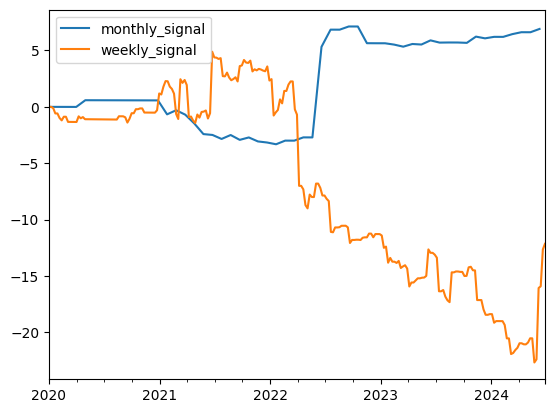

In [9]:
# optimal portfolios (different time frames and trade frequencies)

monthly_freq_return, monthly_freq_vol = info_creating_timed_data(info_rets, info_vols, 720)
monthly_freq_weights = info_build_signal(monthly_freq_return, monthly_freq_vol, 2)
monthly_freq_port = info_build_port(monthly_freq_weights, monthly_freq_return)
(monthly_freq_port.sum(1) - 0.002).cumsum().plot(label='monthly_signal')
plt.legend()
print(f'monthly signal (adjusted for tcosts) Sharpe ratio: out of sample = {sharpe_tcosts(monthly_freq_port['2023-01-01':]) * np.sqrt(52)} \
    total period = {sharpe_tcosts(monthly_freq_port) * np.sqrt(52)}')

info_return, info_vol = info_creating_timed_data(info_rets, info_vols, 168)
info_weight = info_build_signal(info_return, info_vol, 2)
info_portfolio = info_build_port(info_weight, info_return)
(info_portfolio.sum(1) - 0.002).cumsum().plot(label='weekly_signal')
plt.legend()
print(f'weekly signal (adjusted for tcosts) Sharpe ratio: out of sample = {sharpe_tcosts(info_portfolio['2023-01-01':]) * np.sqrt(52)} \
    total period = {sharpe_tcosts(info_portfolio) * np.sqrt(52)}')

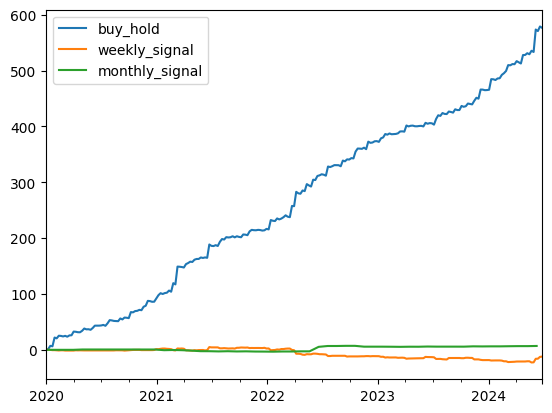

In [10]:
# Comparison 

benchmark_port = info_return
(benchmark_port.sum(1)).cumsum().plot(label='buy_hold')
(info_portfolio.sum(1) - 0.002).cumsum().plot(label='weekly_signal')
(monthly_freq_port.sum(1) - 0.002).cumsum().plot(label='monthly_signal')
plt.legend()

In [11]:
# Significance - weekly signal

X = info_return[['BTCUSDT']]
X = sm.add_constant(X)

Y = info_portfolio[['BTCUSDT']]
results = sm.OLS(Y.astype(float), X.astype(float)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                BTCUSDT   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 10 Jul 2025   Prob (F-statistic):                nan
Time:                        17:17:01   Log-Likelihood:                    nan
No. Observations:                 235   AIC:                               nan
Df Residuals:                     233   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        nan         nan         nan
BTCUSDT           nan        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         10.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# Significance - monthly signal

X = monthly_freq_return[['BTCUSDT']]
X = sm.add_constant(X)

Y = monthly_freq_port[['BTCUSDT']]
results = sm.OLS(Y.astype(float), X.astype(float)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                BTCUSDT   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 10 Jul 2025   Prob (F-statistic):                nan
Time:                        17:17:01   Log-Likelihood:                    nan
No. Observations:                  55   AIC:                               nan
Df Residuals:                      53   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        nan         nan         nan
BTCUSDT           nan        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         4.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
# End of Strategy #1

In [14]:
# Strategy #2: Quant Crypto

In [15]:
# Signal Construction

def res(prices, long_long_term, long_short_term, short_long_term, short_short_term, sr = 0):
    entries = pd.DataFrame(prices['close'] > prices.shift().rolling(long_long_term).max()['close'])
    exit = pd.DataFrame(prices['close'] < prices.shift().rolling(long_short_term).min()['close'])
    position = {}
    position['close'] = prices['close']
    position['entry'] = entries['close']
    position['exit'] = exit['close']
    position['entry point'] = 0.0
    position['exit point'] = 0.0
    # position['have'] = 0
    # position.loc['2009.04.23', 'have'] = 1
    position['return'] = 0.0
    position['test'] = 0.0 #new
    position = pd.DataFrame(position, index=prices.index)
    have = False
    enter = 0
    for i in position.index:
        if have == True: #new
            position.loc[i, 'test'] = position.loc[i, 'close']
        if position.loc[i, 'entry'] == True and have == False:
            # position.loc[i, 'entry point'] = position.loc[i, 'high']
            position.loc[i, 'test'] = position.loc[i, 'close'] #new
            enter = position.loc[i, 'close']
            have = True
        if position.loc[i, 'exit'] == True and have == True:
            position.loc[i, 'exit point'] = position.loc[i, 'close']
            position.loc[i, 'entry point'] = enter
            enter = 0.0
            have = False
    position['return'] = position['exit point'] / position['entry point'] - 1
    smooth = ((position['test'])[(position['test'] != 0)].pct_change())[(position['test'].shift(1) != 0)]
    if sr == 1:
        return smooth - 0.002

    short_entries = pd.DataFrame(prices['close'] < prices.shift().rolling(short_long_term).min()['close'])
    short_exit = pd.DataFrame(prices['close'] > prices.shift().rolling(short_short_term).max()['close'])
    short_position = {}
    short_position['close'] = prices['close']
    short_position['entry'] = short_entries['close']
    short_position['exit'] = short_exit['close']
    short_position['entry point'] = 0.0
    short_position['exit point'] = 0.0
    # position['have'] = 0
    # position.loc['2009.04.23', 'have'] = 1
    short_position['return'] = 0.0
    short_position['short test'] = 0.0
    short_position = pd.DataFrame(short_position, index=prices.index)
    short_have = False
    short_enter = 0.0
    for i in short_position.index:
        if short_have == True:
            short_position.loc[i, 'short test'] = short_position.loc[i, 'close']
        if  short_position.loc[i, 'entry'] == True and short_have == False:
            # position.loc[i, 'entry point'] = position.loc[i, 'high']
            short_position.loc[i, 'short test'] = short_position.loc[i, 'close']
            short_enter = short_position.loc[i, 'close']
            short_have = True
        if short_position.loc[i, 'exit'] == True and short_have == True:
            short_position.loc[i, 'exit point'] = short_position.loc[i, 'close']
            short_position.loc[i, 'entry point'] = short_enter
            short_enter = 0.0
            short_have = False
    
    short_position['return'] = short_position['entry point'] / short_position['exit point'] - 1
    short_smooth = ((short_position['short test'])[(short_position['short test'] != 0)].pct_change() * -1)[(short_position['short test'].shift(1) != 0)]
    if sr == 2:
        return short_smooth - 0.002
    
    sum_stat = prices['close']
    sum_stat = pd.DataFrame(sum_stat)
    sum_stat.columns = ['return']
    sum_stat['return'] = 0.0
    sum_stat.loc[smooth.index] = sum_stat.loc[smooth.index].add(smooth, 0)
    sum_stat.loc[short_smooth.index] = sum_stat.loc[short_smooth.index].add(short_smooth, 0)
    # sum_stat.loc[]['sum test'] = 
    # sum_stat = pd.DataFrame(sum_stat)

    if sr == 0:
        return sum_stat

In [16]:
# Active and Passive (Benchmark) Portfolio Construction 

# Value_dict values came from a grid search, example shown in the cell below
value_dict = {'BTCUSDT': [25, 1, 25, 1], 'ETHUSDT':[25, 1, 11, 1], 'ADAUSDT':[25, 1, 25, 1],'BNBUSDT':[20, 1, 18, 1],'DOTUSDT':[25, 5, 4, 1], 'MATICUSDT':[27, 1, 4, 1]}
# Weighting is SR Proportional 
srt_dict = {'BTCUSDT': 3.65 / 10.33, 'ETHUSDT': 0.95 / 10.33, 'ADAUSDT': 1.68 / 10.33,'BNBUSDT': 1.88 / 10.33,'DOTUSDT': 0.81 / 10.33, 'MATICUSDT': 1.36 / 10.33}
cr_port = px_w['BTCUSDT Close']
cr_port = pd.DataFrame(cr_port)
cr_port.columns = ['BTCUSDT']
buy_hold = px_w['BTCUSDT Close']
buy_hold = pd.DataFrame(buy_hold)
buy_hold.columns = ['BTCUSDT']
for i in univ:
    temp_p = px_w[f'{i} Close']
    temp_p = pd.DataFrame(temp_p)
    temp_p.columns = ['close']
    cr_port[i] = res(temp_p, value_dict[i][0], value_dict[i][1], value_dict[i][2], value_dict[i][3], 0) * srt_dict[i]
    buy_hold[i] = temp_p['close'].pct_change() * srt_dict[i]

In [17]:
# Out of Sample Sharpe
sharpe(cr_port['2023-01-01':]) * np.sqrt(252)

np.float64(2.3868260204533964)

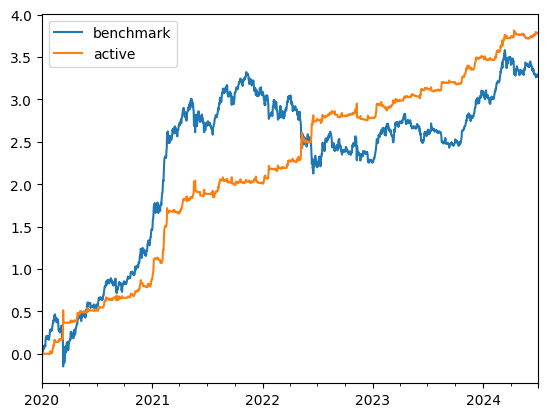

In [18]:
# Comparison

buy_hold.fillna(0).sum(1).cumsum().plot(label = 'benchmark')
((cr_port).sum(1)).cumsum().plot(label='active')
plt.legend()

In [19]:
# Significance 

X = buy_hold.fillna(0).sum(1)
X = sm.add_constant(X)
# Y = pd.DataFrame(Y)
# Y = spy_stat.iloc[X.index]
Y = cr_port.sum(1)
result = sm.OLS(Y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     97.27
Date:                Thu, 10 Jul 2025   Prob (F-statistic):           2.50e-22
Time:                        17:17:03   Log-Likelihood:                 4211.2
No. Observations:                1643   AIC:                            -8418.
Df Residuals:                    1641   BIC:                            -8408.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.000      5.569      0.000       0.002       0.003
0             -0.1340      0.014     -9.862      0.000      -0.161      -0.107
==============================================================================
Omnibus:                     1334.894   Durbin-Watson:                   2.252
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           148357.057
Skew:                           3.118   Prob(JB):                         0.00
Kurtosis:                      49.133   Cond. No.                         29.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

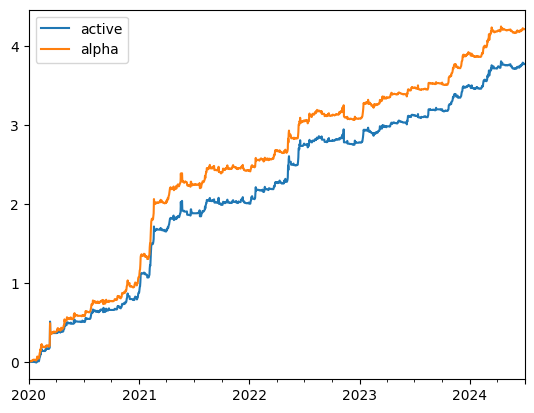

In [20]:
cr_port.sum(1).cumsum().plot(label='active')
(cr_port.sum(1) - (-0.1340 * buy_hold.fillna(0).sum(1))).cumsum().plot(label='alpha')
plt.legend()